### Probably Overkill Imports

In [1]:
# Imports
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import pickle

# Import
# Math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import random
from scipy.stats import norm
import scipy.optimize as optimize
import time
import math as m

# Ez parallelization
from joblib import Parallel, delayed

# File Handling
from sys import getsizeof
import _pickle as pickle
# Alternatively use JSON which will be human readable
# import json

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Custom imports
from MarketGeneratingFunctions.global_cache import Global_Cache
import MarketGeneratingFunctions.base_from_gen as bg
import MarketGeneratingFunctions.pricing_func as pf
from MarketGeneratingFunctions.path_datatype import Path

c:\Users\osc16\miniconda3\envs\d2d\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Load a test dataset (In this case all runs with idx over 800 (where train maxes) :/)

In [5]:
## Load File
with open("ZeroCorrTest","rb") as fp:   # Set Test Data according to what it's trained on
    paths = pickle.load(fp)

### Setup tests just like when testing delta hedge

#### Base Cases

In [6]:
### Unhedged PnL
def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])

### Delta Hedged PnL
if not 'T_s' in vars() or 'T_s' in globals():
    T_s = np.arange(0,21)
from MarketGeneratingFunctions import DeltaHedge
def DeltaFromFunc(path, transaction = False):
    pnl = np.zeros(len(path.CVA)-1)
    swptOldPos = 0
    qOldPos = 0
    for i in range(len(path.CVA)-1):
        t = path.t_s[i]
        Q = [1] + [path.Q_s[j][i] for j in range(1,21)]
        Swapts = [0.0] + [path.Swaptions[j][i] for j in range(0,19)]
        T_sl = T_s.copy()
        
        [SwapsHedge,Qhedge] = DeltaHedge.delta_hedge(Swapts,Q,T_sl,t)

        cost = np.inner(SwapsHedge,Swapts) + np.inner(Qhedge,Q)
        trCost = np.inner(np.abs(swptOldPos-SwapsHedge),Swapts) + np.inner(np.abs(qOldPos-Qhedge),Q)
        
        futureSwapts = [0] + [path.Swaptions[j][i+1] for j in range(0,19)]
        futureQ = [path.Q_s[j][i+1] for j in range(0,21)]
        value = np.inner(SwapsHedge,futureSwapts) + np.inner(Qhedge,futureQ)
        if transaction==True:
            pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost)) - trCost*0.02
        else:
            pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
            
        swptOldPos = SwapsHedge
        qOldPos = Qhedge
    return pnl

pnl_delta_hedge = [None]*(len(paths))
for i in range(len(pnl_without_hedge)):
    pnl_delta_hedge[i] = DeltaFromFunc(paths[i], transaction=False)


#### RL Hedge

In [7]:
import pickle
import torch as th

modelG = PPO.load("Results/Huge/best_model.zip") #<- Set model to load, should be auto from here
action_scale = 2

def rlHedge(path, model, transaction = False):
    pnl = np.zeros(len(path.CVA)-1)
    pfValue = np.zeros(len(path.CVA)-1)
    swptOldPos = 0
    qOldPos = 0
    for i in range(round((len(path.CVA)-1))):
        # Get State
        lambdax = np.tanh(np.log((path.lambdas[i] - 0.001)+1)) if path.lambdas[i] != -0.999 else -1
        r = np.tanh(path.r[i]) 
        t = path.t_s[i]/10 - 1

        Q = [path.Q_s[j][i] for j in range(1,21)]
        Swapts = [0.0] + [path.Swaptions[j][i] for j in range(0,19)]

        Sobs = np.tanh(np.log([a+1 for a in Swapts]))
        Qobs = [(a - 0.5)*2 for a in Q] 

        futureQ = [path.Q_s[j][i+1] for j in range(1,21)]
        futureSwapts = [0.0] + [path.Swaptions[j][i+1] for j in range(0,19)]

        # Create Hedge
        #hedgPos = model.predict(np.asmatrix([lambdax,r,t]), deterministic = True)   #<-  If you're using a model with xs observation space
        hedgPos = model.predict(np.concat([Sobs,Qobs]), deterministic = True)      #<- If you're using a model with full observation space
        #hedgPos = hedgPos[0][0]                                                     #<-  If you're using a model with xs observation space
        hedgPos = hedgPos[0]                                                       #<- If you're using a model with full observation space

        if len(hedgPos) == 2:
            swpt = hedgPos[0]
            Qq = hedgPos[1]
            hedgPos = np.concatenate([np.zeros(19), [swpt], np.zeros(19), [Qq]])*action_scale
        if len(hedgPos) == 40:
            hedgPos = hedgPos*0.1

        swpPos = hedgPos[0:20]
        QPos = hedgPos[20:]

        trCost = np.inner(np.abs(swptOldPos-swpPos),Swapts) + np.inner(np.abs(qOldPos-QPos),Q)

        cost = np.sum(np.inner(swpPos,Swapts) + np.inner(QPos,Q))
        value = np.sum(np.inner(swpPos,futureSwapts) + np.inner(QPos,futureQ))

        pfValue[i] = path.CVA[i+1] - value

        if transaction:
            pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost)) - trCost*0.02
        else:
            pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))

        swptOldPos = swpPos
        qOldPos = QPos
    return pnl, pfValue

pnl_RL_hedge = [None]*(len(paths))
pnl_RL_hedgeb = [None]*(len(paths))
pfValue = [None]*(len(paths))

for i in range(len(pnl_without_hedge)):
    pnl_RL_hedge[i] = rlHedge(paths[i], modelG)
    [pnl_RL_hedgeb[i], pfValue] = rlHedge(paths[i], modelG, transaction = True)   


(-5e-05, 5e-05)

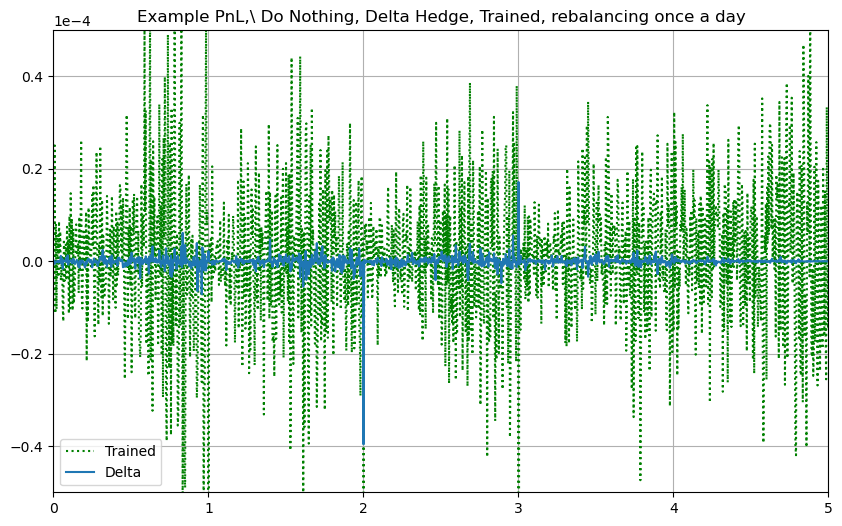

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Example PnL,\\ Do Nothing, Delta Hedge, Trained, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
#plt.plot(paths[49].t_s[1:],pnl_without_hedge[0])
plt.plot(paths[49].t_s[1:],pnl_RL_hedge[0], color = 'green')
plt.plot(paths[49].t_s[1:],pnl_delta_hedge[0])
#plt.plot(paths[0].t_s[1:],pnl_RL_hedgeb[0], linestyle = ':')
plt.legend(['Trained','Delta'])
plt.xlim((0,5))
plt.ylim((-5*1e-5,5*1e-5))

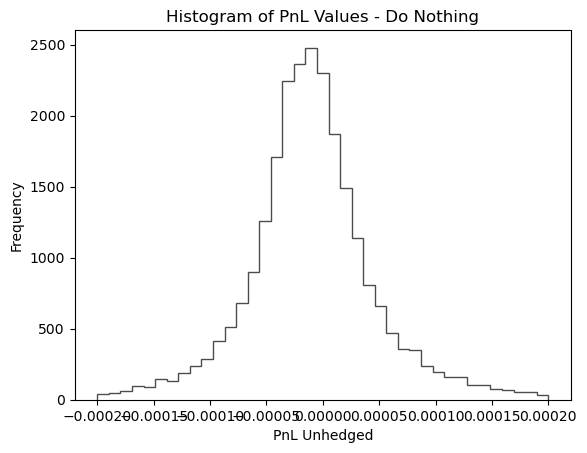

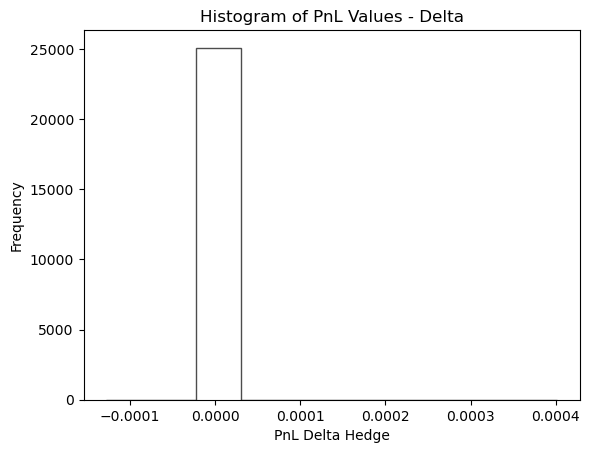

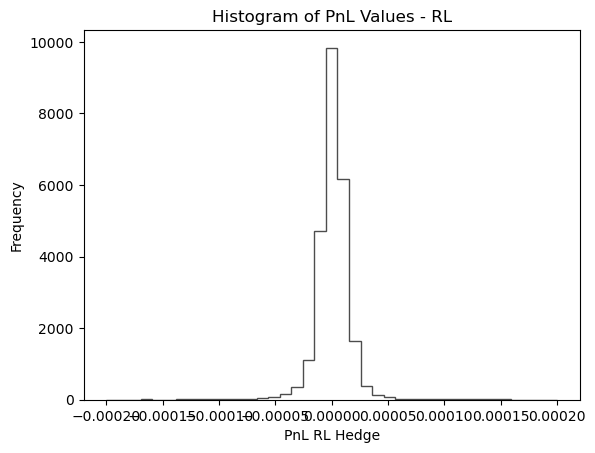

In [9]:
plt.hist([float(a) for b in pnl_without_hedge for a in b[0:251]], histtype='step', bins=np.linspace(-2e-4,2e-4,40), edgecolor='black', alpha=0.7)
plt.xlabel("PnL Unhedged")
plt.ylabel("Frequency")
#plt.xlim(-2*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of PnL Values - Do Nothing")
plt.show()
plt.hist([float(a) for b in pnl_delta_hedge for a in b[0:251]], histtype='step',  edgecolor='black', alpha=0.7, color='black')
plt.xlabel("PnL Delta Hedge")
plt.ylabel("Frequency")
#plt.xlim(-2*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of PnL Values - Delta")
plt.show()
plt.hist([float(a) for b in pnl_RL_hedge for a in b[0:251]], histtype='step', bins=np.linspace(-2e-4,2e-4,40), edgecolor='black', alpha=0.7)
plt.xlabel("PnL RL Hedge")
plt.ylabel("Frequency")
#plt.xlim(-2*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of PnL Values - RL")
plt.show()

### Find key statistics

In [10]:
# Just run this once you've run the above
in_sample = [a for b in pnl_without_hedge for a in b[0:251]]

VaR = np.quantile(in_sample, 0.05)
MeanL1 = np.mean(np.abs(in_sample))
ES = np.mean(np.abs([a for a in in_sample if a <= VaR]))

print("DailyVar")
print(VaR)
print("Mean Loss")
print(MeanL1)
print("ES")
print(ES)


DailyVar
-0.00010984024480339311
Mean Loss
4.792652243012312e-05
ES
0.00017894414715607975


In [11]:
VaRs = []
ESs = []
Means = []
MaxDrawdowns = []

def max_drawdown(series):
    cumulative_max = np.maximum.accumulate(series)
    drawdowns = (series - cumulative_max)/cumulative_max
    max_drawdown = np.min(drawdowns)
    return max_drawdown

for b in pnl_delta_hedge:
    sample = b[:503] #2 year VaR, ES
    var = np.percentile(sample,5)
    es = np.mean([a for a in sample if a <= var])  # Expected Shortfall = mean of losses below VaR
    mean_loss = np.mean(np.abs(sample))
    VaRs.append(var)
    ESs.append(es)
    Means.append(mean_loss)


for b in pfValue:
    sample = b[:503] #2 year VaR, ES
    MaxDrawdowns.append(max_drawdown(sample))

# Now take the mean across all paths
mean_VaR = np.mean(VaRs)
mean_ES = np.mean(ESs)
mean_loss = np.mean(Means)
MaxDrawdown = np.mean(MaxDrawdowns)

print("Average VaR over paths:", mean_VaR)
print("Average ES over paths:", mean_ES)
print("Mean:", mean_loss)
print("Max Drawdown:", MaxDrawdown)


Average VaR over paths: -0.00013888286903527487
Average ES over paths: -0.00021019176330268056
Mean: 4.792652243012312e-05
